In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [2]:
gt_train_coord = pickle.load( open( "../import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "../import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "../import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "../import_dataset_2/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

((11, 5157, 2),
 torch.Size([5157, 11, 4]),
 (10, 5157, 2),
 torch.Size([5157, 10, 164]))

## VALIDATION SET

In [3]:
gt_validation_coord = pickle.load( open( "../import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "../import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "../import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "../import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

((11, 1719, 2),
 torch.Size([1719, 11, 4]),
 (10, 1719, 2),
 torch.Size([1719, 10, 164]))

### Model

In [5]:
from torch import optim

inp_size = np.int(inputs_train.shape[2]/4)
lr = 0.01
lstm = LSTM(input_size = inputs_train.shape[2], output_size = 4, num_layers=2, hidden_size=128)
optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-4)
criterion = nn.MSELoss()

In [6]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

epochs = 5
steps = 0
print_every = 323
running_loss = 0

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    total_train_loss=0
    steps_bis = 0
    if (e+1)%10==0:
        lr /= 2
        optimizer = optim.Adam(lstm.parameters(), lr=lr)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()

        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4

        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    valcoord = valcoord.permute([1,0,2])
                    valgt = valgt.permute([1,0,2])
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    predicted_bis = predicted[:,:,0:2].clone()
                    
                    for i in range(10):
                        if i == 0:
                            predicted_bis[i, :, 0:2] = inputs[-1, :, 0:2] + predicted[i, :, 2:]*0.4
                        else:
                            predicted_bis[i, :, 0:2] = predicted[i - 1, :, 0:2] + predicted[i, :, 2:]*0.4
                    val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                
                loss_val.append(val_loss/ii)
                running_loss = 0
                start = time.time()
    loss_train.append(total_train_loss/steps_bis)

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1/5.. Validation loss: 2.4741.. Training loss: 3.4926.. 0.0716 s/batch
Epoch: 2/5.. Validation loss: 2.1648.. Training loss: 2.1222.. 0.0603 s/batch
Epoch: 3/5.. Validation loss: 1.8221.. Training loss: 1.8239.. 0.0881 s/batch
Epoch: 4/5.. Validation loss: 1.8544.. Training loss: 1.7346.. 0.0740 s/batch
Epoch: 5/5.. Validation loss: 1.8261.. Training loss: 1.6434.. 0.0759 s/batch


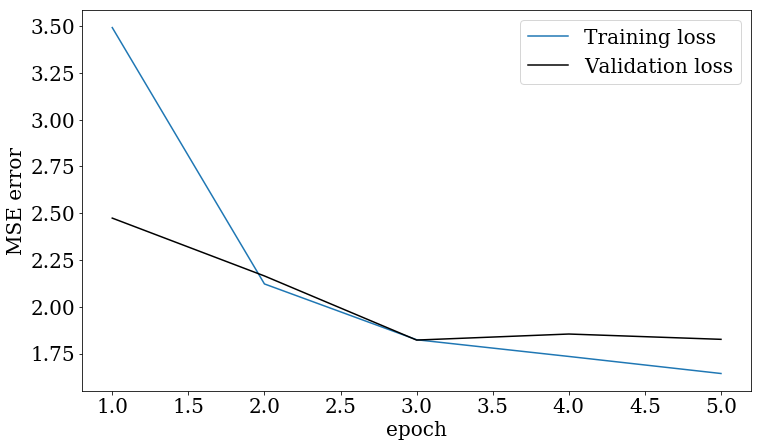

In [7]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()
plt.savefig(r'./figures/loss_full.pdf', bbox_inches='tight')

In [8]:
torch.save(lstm.state_dict(), 'fullLSTM_4.pt')